# 2021 유행어

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('../data_inword/2021년 유행어.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20230929,업계 트렌드를 알려주는 2021년 소프트웨어 개발 유행어 TOP 10 2021년 소...,업계 트렌드를 알려주는 <b>2021년<\/b> 소프트웨어 개발 <b>유행어<\/b...,업계 트렌드를 알려주는 2021년 소프트웨어 개발 유행어 TOP 10
1,20210609,2021년 벌써 반절이나 지나고 있는데요. 시간이 생각보다 정말 빨리 지나가는것 같...,오늘은 2021년 신조어 모음 그리고 <b>2021년 유행어<\/b> 모음을 알아봤...,2021년 신조어 모음 유행어와 트렌드 모두 알자
2,20240412,"스불재, 알잘딱깔센, 부캐 뜻 2024 mz세대 유행어 신조어 테스트 모음 영어로 ...","스불재, 알잘딱깔센, 부캐 뜻 2024 mz세대 <b>유행어<\/b> 신조어 테스트...","스불재, 알잘딱깔센, 부캐 뜻 2024 mz세대 유행어 신조어 모음 영어로"
3,20220207,2021년 한국에서는 많은 신조어들이 생겨났습니다. 시대의 흐름에 따라 해마다 새로...,오늘은 <b>2021년<\/b> 중국에서 유행했던 <b>유행어<\/b>와 신조어를 ...,2021년 중국에서 유행했던 유행어&신조어
4,20210723,안녕하세요~ 진순대 식구 여러분~ 오늘은 2021년 신조어와 유행어를 알아볼께요^^...,안녕하세요~ 진순대 식구 여러분~ 오늘은 2021년 신조어와 유행어를 알아볼께요^^...,2021년 신조어 &유행어 다 모여~!


## 1. 전처리

In [3]:
## 사용자 정의 단어 추가 
kiwi = Kiwi()

new = ['무지성', '얼죽아', '아이스', '아메리카노', '박박', '한심좌', '좌', '머선129', '머선', '레게노', 
       '잼민이', '잼민', '재질', '손민수', '스불재', '고진감래', '일취월장', 
       '억텐', '찐텐', '당모치', '삼귀다', '알잘딱깔센', '얼죽아', '부캐', '루삥뽕', 'ㅋㅋ루삥뽕', 
       '쫌쫌따리', '무야호', '만반잘부', '킹리적갓심', '준며들다', '커피', 'HI에이치아이', 'HI', '헤이치아이', 
       '매드몬스터', '루돌프', '레드코', '피식대학', '탄', '제이호']

for i in new:
    kiwi.add_user_word(i,'NNP')

In [4]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [5]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['유행어', '신조어', '2021년', '생각', '올해', '사람', '코로나', '대하', '시작', '일본', 
                        '사용', '한국', '사랑', '때문', '중국', '사진', '미국', '사회', '영상', '단어', 
                        '표현', '블로그', '정도', '인기', '배우', '모습', '이야기', '활동', '세대', '부모', 
                        '출처', '세계', '마음', '친구', '가지', '유행', '행복', '작품', '출연', '이후', 
                        '상황', '다양', '관련', '최고', '멤버', '제공', '가능', '게임', '대상', '처음', 
                        '일상', '요즘', '보이', '여행', '진행', '프로그램', '시대', '소개', '성공', '느낌', 
                        '정보', '콘텐츠', '네이버', '오늘', '생활', '내용', '기업', '투자', '경제', '대표', 
                        '캐릭터', '시장', '광고', '트렌드', '이름', '부분', '엄마', '필요', '가족', '기억', 
                        '이유', '인터넷', '경우', '성장', '세상', '관심', '당시', '공부', '감사', '마지막', 
                        '대화', '시즌', '등장', '기록', '사이', '준비', '인하', '영어', '데뷔', '발표', 
                        '공개', '개인', '나라', '중요', '자리', '회사', '여자', '서울', '도전', '교육', 
                        '기준', '채널', '운동', '대한민국', '변화', '소비', '제품', '경험', '가격', '추천', 
                        '기술', '포스팅', '국내', '학교', '여성', '하루', '나이', '유명', '이미지', '청년', 
                        '건강', '카페', '방법', '연기', '활용', '지금', '정리', '운영', '작년', '남자', 
                        '인생', '서비스', '정부', '중국어', '시절', '노력', '기사', '그룹', '브랜드', '일본어', 
                        '이해', '거리', '언니', '최근', '결과', '이용', '선택', '현실', '평가', '설명', 
                        '아래', '수업', '지역', '확인', '인간', '아빠', '예능', '목표', '네이버', '의미', 
                        '대학', '환경', '부동산', '국민', '해당', '음식', '능력', '주식', '블로그', '산업', 
                        '마케팅', '증가', '선물', '국가', '뉴스', '아침', '용어', '작가', '관리', '학생', 
                        '언어', '상승', '단계', '선수', '상품', '포함', '영화', '과학',  '화제', '사건', 
                        '소리', '온라인', '지원', '기분', '스타', '감독', '기대', '제작', '개발', '행동', 
                        '발견', '시사', '영향', '예정', '상태', '가수', '사업', '도움', '졸업', '자체', 
                        '판매', '조사', '선생', '탄생', '결혼', '줄임', '방식', '얼굴', '저녁', '계획', 
                        '자료', '질문', '미래', '경기', '본인', '촬영', '예상', '참여', '출시', '선정', 
                        '새해', '년대', '전체', '연말', '주목', '현상', '기간', '스타일', '수준', '문장', 
                        '역사', '얘기', '패션', '과정', '추가', '소식', '시기', '머리', '안녕하세요', '분위기', 
                        '공간', '시리즈', '내년', '이전', '맥주', '존재', '실패', '가치', '분야', '프로', 
                        '공식', '순간', '구독', '플랫폼', '접종', '대통령', '아이돌', '달러', '이벤트', '리그', 
                        '디지털', '데이터', '도쿄', '공유', '차이', '유지' 
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [6]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [7]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    # wordclass_column = 'wordclass_' + column 
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 2min 19s
Wall time: 5min 36s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20230929,업계 트렌드를 알려주는 2021년 소프트웨어 개발 유행어 TOP 10 2021년 소...,업계 트렌드를 알려주는 b2021년b 소프트웨어 개발 b유행어b TOP 10 b20...,업계 트렌드를 알려주는 2021년 소프트웨어 개발 유행어 TOP 10,업계 알리 주 소프트웨어 소프트웨어 소프트웨어 업계 은 프론트 엔드 백 엔드 조어 ...,업계 알리 주 소프트웨어 소프트웨어 소프트웨어 업계,업계 알리 주 소프트웨어
1,20210609,2021년 벌써 반절이나 지나고 있는데요 시간이 생각보다 정말 빨리 지나가는것 같아...,오늘은 2021년 신조어 모음 그리고 b2021년 유행어b 모음을 알아봤어요 새롭게...,2021년 신조어 모음 유행어와 트렌드 모두 알자,반절 뜻 지 고 전 모음 알 식 모음 대로 무지 무지 성 애니 데 진격의 거인 지성...,은 모음 모음 알 면 수록 뜻 지,모음 알
2,20240412,스불재 알잘딱깔센 부캐 뜻 2024 mz세대 유행어 신조어 테스트 모음 영어로 안녕...,스불재 알잘딱깔센 부캐 뜻 2024 mz세대 b유행어b 신조어 테스트 모음 영어로 ...,스불재 알잘딱깔센 부캐 뜻 2024 mz세대 유행어 신조어 모음 영어로,스불재 알잘딱깔센 부캐 뜻 테스트 모음 의학 노트 쌤 니 스불재로 치킨 스불재 재앙...,스불재 알잘딱깔센 부캐 뜻 테스트 모음 알 깔 유래 방송,스불재 알잘딱깔센 부캐 뜻
3,20220207,2021년 한국에서는 많은 신조어들이 생겨났습니다 시대의 흐름에 따라 해마다 새로운...,오늘은 b2021년b 중국에서 유행했던 b유행어b와 신조어를 알아보겠습니다 위안위죠...,2021년 중국에서 유행했던 유행어신조어,흐름 해 수 데 은 위안위죠우 메타버스 바이두 메타버스 위안위죠우 방송 후 바이두 ...,은 위안위죠우 메타버스 바이두 메타버스 위안위죠우,
4,20210723,안녕하세요 진순대 식구 여러분 오늘은 2021년 신조어와 유행어를 알아볼께요 Ale...,안녕하세요 진순대 식구 여러분 오늘은 2021년 신조어와 유행어를 알아볼께요 Ale...,2021년 신조어 유행어 다 모여,순대 식구 은 알 스불재 말 스불재 재앙 말 자초 이 불행 탓 니 고진감래 고진감래...,순대 식구 은 알 스불재 말 스불재 재앙 말,


In [8]:
# 전처리한 결과 csv로 저장 
df.to_csv('21유행어_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [9]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts


### [preprocessed_body]

In [10]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [11]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
9256,방송,576
5788,드라마,482
8293,문화,409
8273,문제,404
18346,유튜브,343
4083,노래,329
20087,재미,208
9435,백신,205
24828,테스트,195
11220,사실,193


In [12]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['방송',
 '드라마',
 '문화',
 '문제',
 '유튜브',
 '노래',
 '재미',
 '백신',
 '테스트',
 '사실',
 '고민',
 '음악',
 '매력',
 '루피',
 '댓글',
 '커피',
 '개그맨',
 '라면',
 '올림픽',
 '시청',
 '그림',
 '박지훈',
 '노동자',
 '오징어',
 '여름',
 '일반',
 '주류',
 '웃음',
 '예전',
 '공연']

In [13]:
## 한 번 해본 것

for i in all_words_body['word']:
    if i in new:
        count = all_words_body.loc[all_words_body['word'] == i, 'count'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '커피' is: 164
The count for '무야호' is: 79
The count for '스불재' is: 51
The count for '부캐' is: 41
The count for '재질' is: 40
The count for '고진감래' is: 28
The count for '아이스' is: 27
The count for '아메리카노' is: 24
The count for '루삥뽕' is: 20
The count for '손민수' is: 18
The count for '일취월장' is: 17
The count for '레게노' is: 17
The count for '알잘딱깔센' is: 16
The count for '머선' is: 14
The count for '당모치' is: 11
The count for '삼귀다' is: 9
The count for '쫌쫌따리' is: 9
The count for '얼죽아' is: 7
The count for '억텐' is: 7
The count for '찐텐' is: 6
The count for '잼민' is: 5
The count for '루돌프' is: 3
The count for '잼민이' is: 1
The count for '한심좌' is: 1
The count for '매드몬스터' is: 1


### [preprocessed_description]

In [14]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
1780,제목,47
704,문화,14
2245,프로필,14
2405,후기,14
2124,테스트,13
569,리뷰,12
93,결산,12
2093,키워드,11
780,방송,11
2055,코리아,11


### [preprocessed_title]

In [15]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
1465,방송,49
903,드라마,27
3663,최신,22
1320,문화,20
2641,오징어,20
2865,유튜브,19
3940,테스트,18
4029,티비,16
1848,생기,16
631,넷플릭스,15


# 3. TF-IDF

In [16]:
# ## 참고 사이트
# ## -> https://foreverhappiness.tistory.com/30
# ## -> https://foreverhappiness.tistory.com/35
# ## -> https://foreverhappiness.tistory.com/37
# ## 너무 오래 걸려서 안 돌림


# import pandas as pd
# from tqdm import tqdm
# from konlpy.tag import Okt
# from sklearn.feature_extraction.text import CountVectorizer

# # DTM (Document-Term Matrix) creation using Scikit-Learn's CountVectorizer
# # DTM(Document-Term Matrix) 생성 함수
# def NLP_DTM(df):
#     # 타이틀 리스트를 데이터프레임의 'preprocessed_title' 열에서 가져옴
#     title_lst = df['preprocessed_title']
    
#     # 불용어 리스트를 정의
#     stop_words_list = ['사람', '대하']
    
#     # Okt 형태소 분석기를 초기화
#     tagger = Okt()

#     # 결과를 저장할 DataFrame 초기화
#     result_df = pd.DataFrame()

#     # 타이틀 리스트를 순회하며 진행도를 표시
#     for title in tqdm(title_lst, desc='타이틀 리스트 진행도'):
#         # CountVectorizer 객체를 초기화
#         cv = CountVectorizer()

#         # 각 문서의 말뭉치를 저장할 리스트를 초기화
#         corpus = []

#         # 문서 진행도를 표시하며 타이틀 리스트의 각 요소에 대해 반복
#         for i in tqdm(range(len(df['preprocessed_body'])), desc='문서 진행도'):
#             # 각 타이틀에 대해 명사 리스트를 생성합니다.
#             n_lst = tagger.nouns(df['preprocessed_body'].iloc[i])
#             corpus.append(' '.join(n_lst))

#         # 말뭉치 데이터를 사용해 DTM(Document-Term Matrix)을 생성
#         DTM_array = cv.fit_transform(corpus).toarray()
        
#         # DTM의 각 열이 어떤 단어에 해당하는지 feature_names에 저장
#         feature_names = cv.get_feature_names_out()

#         # DTM 배열을 DataFrame 형식으로 변환
#         DTM_df = pd.DataFrame(DTM_array, columns=feature_names)
        
#         # 불용어 리스트에 있는 단어들을 DTM DataFrame에서 제거
#         DTM_df.drop(columns=stop_words_list, inplace=True, errors='ignore')
        
#         # 결과 DataFrame에 현재 DTM DataFrame을 추가
#         result_df = pd.concat([result_df, DTM_df], axis=0)

#     return result_df


# # %%time
# dtm_df = NLP_DTM(df)
# dtm_df

## 교수님 코드

In [17]:
## DTM (Document Term Matrix)
## 이거 안 하고 바로 TF-IDF로 가도 됨

import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer


documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
results = vector.fit_transform(documents).toarray()

results

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
## TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
dtm = vector.fit_transform(documents).toarray()


vector = TfidfVectorizer(vocabulary=word_dict)
tfidf = vector.fit_transform(documents).toarray()

tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0973667 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05823986, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03673085, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03377884, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 가정: df는 미리 전처리된 텍스트 데이터 프레임
documents = df['preprocessed_body']
word_dict = all_word_counts['word'].tolist()

# TF-IDF 계산
vectorizer = TfidfVectorizer(vocabulary=word_dict)
tfidf_matrix = vectorizer.fit_transform(documents).toarray()

# 각 단어의 TF-IDF 값을 집계
tfidf_scores = tfidf_matrix.sum(axis=0)
words = vectorizer.get_feature_names_out()

# 데이터 프레임 생성
tfidf_df = pd.DataFrame({'words': words, 'counts': tfidf_scores})

# TF-IDF 값이 큰 순서로 정렬
tfidf_df = tfidf_df.sort_values(by='counts', ascending=False).reset_index(drop=True)


tfidf_df

,words,counts
0,드라마,14.892149
1,방송,14.619811
2,문화,13.085364
3,노래,12.397492
4,문제,11.365827
...,...,...
4067,자이,0.000000
4068,송민형,0.000000
4069,천년,0.000000
4070,화복이로세,0.000000


In [20]:
## 한 번 해본 것

for i in tfidf_df['words']:
    if i in new:
        count = tfidf_df.loc[tfidf_df['words'] == i, 'counts'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '커피' is: 7.000298560614146
The count for '무야호' is: 5.904992924536557
The count for '스불재' is: 3.8407313381239483
The count for '재질' is: 3.2044988786610027
The count for '고진감래' is: 2.568127155495849
The count for '부캐' is: 1.9782762265243152
The count for '레게노' is: 1.774373697950765
The count for '머선' is: 1.5625601754104488
The count for '알잘딱깔센' is: 1.4704439253743395
The count for '일취월장' is: 1.4104589978921167
The count for '당모치' is: 1.3011637253026123
The count for '쫌쫌따리' is: 1.073493553341243
The count for '매드몬스터' is: 0.10869333693874898
The count for '잼민이' is: 0.06080101203817352


# 4. 워드 클라우드

## 필요한 모듈 임포트

In [21]:
from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline

import konlpy

## WordCloud 클래스의 객체 생성

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [22]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'방송': 576,
 '드라마': 482,
 '문화': 409,
 '문제': 404,
 '유튜브': 343,
 '노래': 329,
 '재미': 208,
 '백신': 205,
 '테스트': 195,
 '사실': 193,
 '고민': 185,
 '음악': 168,
 '매력': 167,
 '루피': 165,
 '댓글': 164,
 '커피': 164,
 '개그맨': 163,
 '라면': 159,
 '올림픽': 158,
 '시청': 152,
 '그림': 152,
 '박지훈': 151,
 '노동자': 145,
 '오징어': 145,
 '여름': 143,
 '일반': 143,
 '주류': 143,
 '웃음': 143,
 '예전': 142,
 '공연': 142,
 '지속': 142,
 '소비자': 141,
 '티비': 141,
 '역할': 141,
 '효과': 141,
 '발전': 140,
 '청소년': 139,
 '센터': 139,
 '특징': 139,
 '기본': 139,
 '개월': 138,
 '아파트': 138,
 '사전': 138,
 '인물': 138,
 '작성': 137,
 '베트남': 137,
 '현재': 137,
 '입장': 136,
 '소득': 136,
 '대신': 136,
 '시험': 135,
 '장면': 135,
 '주택': 135,
 '주변': 135,
 '코리아': 135,
 '비교': 134,
 '반응': 134,
 '구매': 134,
 '오랜만': 133,
 '수익': 133,
 '직업': 133,
 '비트코인': 133,
 '발생': 133,
 '모델': 132,
 '부족': 132,
 '인스타그램': 131,
 '마무리': 131,
 '생산': 131,
 '자유': 130,
 '정책': 130,
 '상대': 129,
 '규모': 129,
 '언급': 129,
 '코너': 129,
 '행사': 128,
 '생일': 128,
 '넷플릭스': 128,
 '동영상': 128,
 '자연': 128,
 '소설': 127,
 '관계': 127,
 '대중'

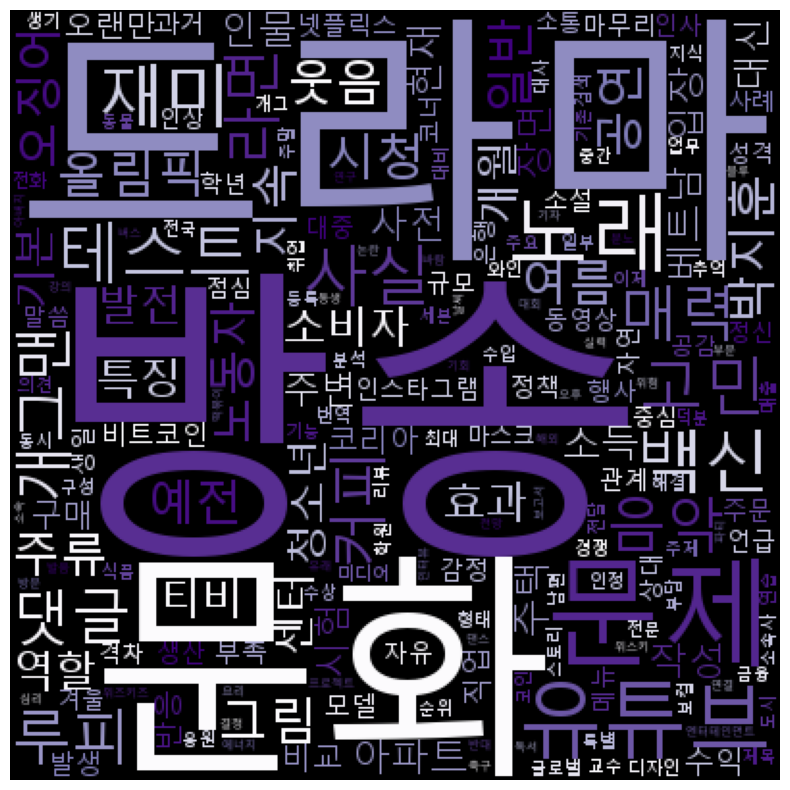

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Purples')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기